# PID Temperature Controller
Implemented in VHDL for Basys-3 FPGA using Vivado. 

Implementation details:
* 4bit target mapped to switches on board.
* Fixed-point arithmetic in Q8.8, manual implementation, not using fixed_pkg. 
* The plant is assumed to be a heat sink, like a water tank, to which heat is added from a source at a fixed temperature (like a stove burning hot gas beneath).
* The controller controls the flow of gas, but not the temperature thereof. 

```mermaid
graph LR
    %% --- Define all nodes first ---
    N_Target["target<br> (4bit)"]
    %% Using Sigma for the summing junction N_SumError
    N_SumError((Σ))
    N_P["pid_pterm.vhd (Kp)"]
    N_I["pid_iterm.vhd (Ki)"]
    N_D["pid_dterm.vhd (Kd)"]
    %% Using Sigma for the summing junction N_SumPID
    N_SumPID((Σ))
    %% Matched Plant node text to your screenshot
    N_Plant["plant2.vhd"]

    %% --- Define links between nodes ---
    N_Target --(+)--> N_SumError
    N_SumError --error_calc.vhd--> N_P
    N_SumError --error_calc.vhd--> N_I
    N_SumError --error_calc.vhd--> N_D

    N_P --> N_SumPID
    N_I --> N_SumPID
    N_D --> N_SumPID

    N_SumPID --control_in--> N_Plant
    N_Plant --(-)--> N_SumError
```

## Phase 1: P-term only. 
We develop all the code to run a p-only controller. Signals are exposed at the top level to export signals to csv, plotted below.

Set target to "0100" (4 in decimal).

On the plot below, we see two issues with the p-only controller:
1. The error oscillates before settling and,
2. The error does not actually settle very close to zero. 

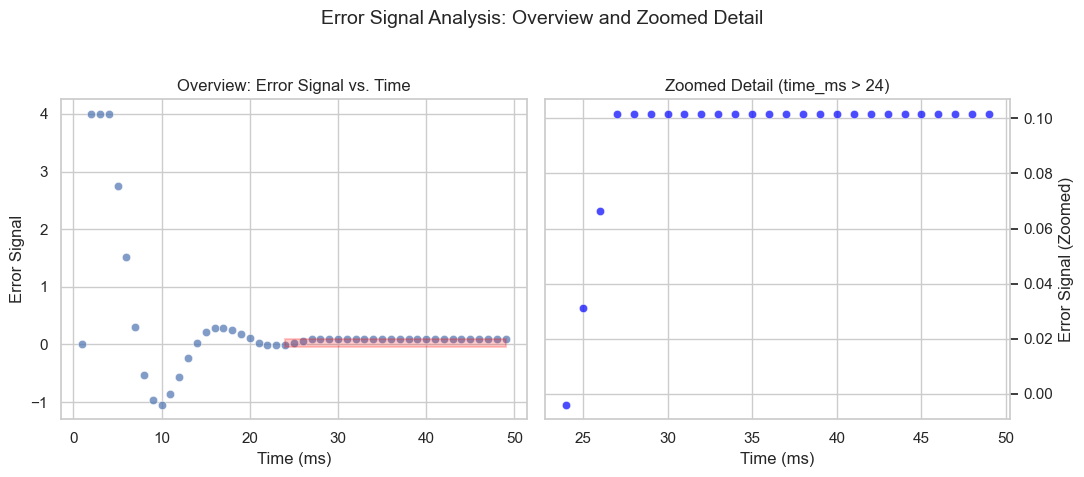

In [61]:
import importlib, polars as pl, phase1_plotter
# Library below is a separate script I wrote to make the plots.  
importlib.reload(phase1_plotter)

# Preprocess the data
sim_data = r'C:\prog\fpga\PID_temp_controller\PID_temp_controller.sim\sim_1\behav\xsim\pid_simulation_data.csv'
df = pl.read_csv(sim_data)
dfp = df.with_columns(((pl.col('Time')*1e-9)*1e3).alias('time_ms'))

my_figure = phase1_plotter.create_plot(dfp,24)
plt.show()